In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [61]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [62]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [63]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [64]:
for col in df_jhu.columns.values:
    print(col)
    print(df_jhu[col].isna().sum())

State
0
Area_Name
0
Rural-urban_Continuum Code_2013
52
Urban_Influence_Code_2013
52
Economic_typology_2015
130
POP_ESTIMATE_2018
0
N_POP_CHG_2018
79
Births_2018
79
Deaths_2018
79
NATURAL_INC_2018
79
INTERNATIONAL_MIG_2018
79
DOMESTIC_MIG_2018
79
NET_MIG_2018
79
RESIDUAL_2018
79
GQ_ESTIMATES_2018
79
R_birth_2018
79
R_death_2018
79
R_NATURAL_INC_2018
79
R_INTERNATIONAL_MIG_2018
79
R_DOMESTIC_MIG_2018
79
R_NET_MIG_2018
79
Less than a high school diploma 2014-18
0
High school diploma only 2014-18
0
Some college or associate's degree 2014-18
0
Bachelor's degree or higher 2014-18
0
Percent of adults with less than a high school diploma 2014-18
0
Percent of adults with a high school diploma only 2014-18
0
Percent of adults completing some college or associate's degree 2014-18
0
Percent of adults with a bachelor's degree or higher 2014-18
0
POVALL_2018
80
CI90LBAll_2018
80
CI90UBALL_2018
80
PCTPOVALL_2018
80
CI90LBALLP_2018
80
CI90UBALLP_2018
80
POV017_2018
80
CI90LB017_2018
80
CI90UB017_2018


In [65]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips']

In [66]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
    return set(Y.fips.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [81]:
cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
cum_deaths = cum_deaths.iloc[1:]
def get_cum_deaths(fips, clip_zeros=True):
    idx = cum_deaths.index[cum_deaths['countyFIPS'] == fips].values[0]
    county_deaths = cum_deaths.loc[cum_deaths['countyFIPS'] == fips]
    dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_deaths.columns)):
        y.append(county_deaths.loc[idx,county_deaths.columns[i]])
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            return X[i:], y[i:]

cum_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")
cum_cases = cum_cases.iloc[1:]
cum_cases = cum_cases.iloc[:, :-1]
def get_cum_cases(fips,clip_zeros=True):
    idx = cum_cases.index[cum_cases['countyFIPS'] == fips].values[0]
    county_cases = cum_cases.loc[cum_cases['countyFIPS'] == fips]
    dates = pd.to_datetime(county_cases.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_cases.columns)):
        y.append(county_cases.loc[idx,county_cases.columns[i]])
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            return X[i:], y[i:]

In [72]:
NYT_counties_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == 1005, :]
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
def get_delta_deaths(fips, clip_zeros=False):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.deaths.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

def get_delta_cases(fips, clip_zeros=False):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.cases.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

# returns an X, y where y[i] is the number of deaths on day i divided by the running average
def get_delta_deaths_ratio(fips, clip_zeros=False, avg_period=5):
    X_raw, y_raw = get_delta_deaths(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))
def get_delta_cases_ratio(fips, clip_zeros=False, avg_period=5):
    X_raw, y_raw = get_delta_cases(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))

## Simple OLS

In [22]:
def get_XY(features, delta_y, look_back_y, get_y):
    df = df_jhu[features]
    df = df[df.fips % 1000 != 0]
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    df = df[df.POP_ESTIMATE_2018 > 1000] # restrict to large counties since getting lots of data is difficult

    # fill out missing data
    df.at['02158', 'Area in square miles - Land area'] = 19673
    df.at['02158', 'Density per square mile of land area - Population'] = 0.44
    df.at['46102', 'Area in square miles - Land area'] = 2097
    df.at['46102', 'Density per square mile of land area - Population'] = 6.5
    
    n, d = df.shape
    col_names = []
    for i in range(look_back_y):
        col_name = "y at t = -%d" %i
        col_names.append(col_name)
        df[col_name] = np.zeros(n)
    Y = []
    for fips in df.index:
        X, ys = get_y(int(fips))
        if len(ys) == 0:
            Y.append(0)
            continue
        Y.append(ys[-1])
        for i in range(look_back_y):
            if i + delta_y < len(ys):
                df.at[fips, col_names[i]] = ys[-1 - i - delta_y]
    df['target'] = Y
    return df

In [23]:
df_res = get_XY(features, 5, 5, get_delta_deaths)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [99]:
import statsmodels.api as sm
X = df_res[df_res.columns[2:-1]]
y = df_res['target']

In [36]:
X_test = X.iloc[-1000:]
y_test = y.iloc[-1000:]
X_train = X.iloc[:-1000]
y_train = y.iloc[:-1000]
model = sm.OLS(y_train,X_train)
result = model.fit()
print(result.summary())


yhat = result.predict(X_test)                    
ybar = np.sum(y_test)/len(y_test)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y_test - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
print("R squared is %f" % (ssreg / sstot))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     3497.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:40:44   Log-Likelihood:                -4184.4
No. Observations:                2106   AIC:                             8409.
Df Residuals:                    2086   BIC:                             8522.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

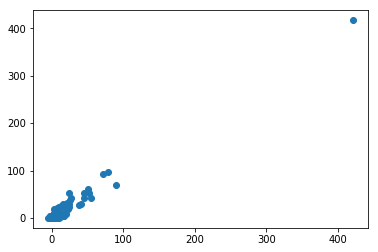

In [38]:
plt.scatter(result.predict(X), y)

## Augmented Dickey Fuller Test for Stationary Time Series

In [55]:
import statsmodels.tsa.stattools as ts
X, y = get_delta_deaths(36061)
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.441649
P-Value                  0.902909
# Lags Used              2.000000
# Observations Used     44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Conclude: time series is stationary

In [41]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = get_delta_deaths_ratio(fips, clip_zeros=True)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/sean/anaconda3/lib/python3.7/site-pac

stationary 817, non-stat 200


## ARIMA Model

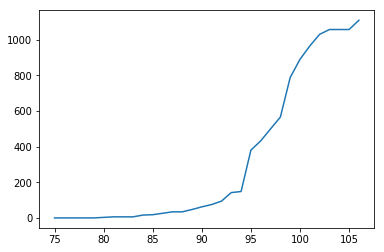

In [153]:
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163), Queens(36059), King (nyc) (36047)
X, y = get_cum_deaths(36059)
plt.plot(X,y)

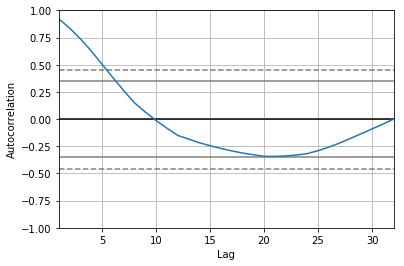

In [154]:
autocorrelation_plot(y)

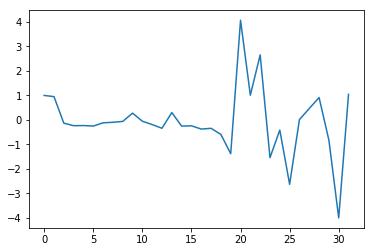

In [155]:
plt.plot(pacf(y))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   30
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -160.032
Method:                       css-mle   S.D. of innovations             48.301
Date:                Fri, 17 Apr 2020   AIC                            336.064
Time:                        17:42:18   BIC                            347.273
Sample:                             2   HQIC                           339.650
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7182      4.582      0.157      0.877      -8.263       9.699
ar.L1.D2.y    -1.5910      0.178     -8.960      0.000      -1.939      -1.243
ar.L2.D2.y    -0.9434      0.342     -2.762      0.0

/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


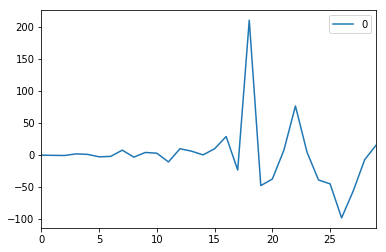

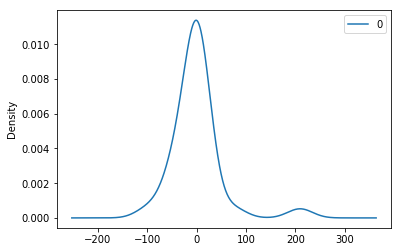

                0
count   30.000000
mean    -0.188397
std     49.953137
min    -98.751794
25%    -10.478184
50%     -0.543870
75%      6.555116
max    209.800998


In [156]:
model = ARIMA(y, order=(5,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

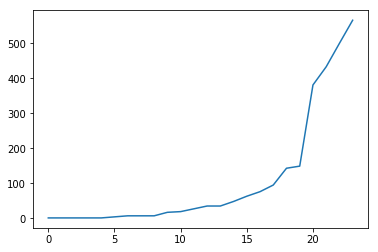

In [157]:
train_sz = int(len(y) * .75)
train_y, test_y = y[:-8], y[-8:]
plt.plot(train_y)

In [165]:
model= ARIMA(train_y, order=(4,2,1))
model_fit = model.fit(disp=0)
pred = model_fit.forecast(8)[0]
plt.plot(test_y)
plt.plot(pred, color='red')
plt.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.